In [5]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline 

import statsmodels.api as sm
from patsy import dmatrices

Populating the interactive namespace from numpy and matplotlib


In [6]:
board = pd.read_csv('bgg_db_2018_01.csv', index_col=2).dropna()

board[:5]

,rank,bgg_url,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
game_id,,,,,,,,,,,,,,,,,,,
174430,1,https://boardgamegeek.com/boardgame/174430/glo...,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
161936,2,https://boardgamegeek.com/boardgame/161936/pan...,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
182028,3,https://boardgamegeek.com/boardgame/182028/thr...,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chv�til,4.3538
12333,4,https://boardgamegeek.com/boardgame/12333/twil...,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
167791,5,https://boardgamegeek.com/boardgame/167791/ter...,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


In [24]:
#DATA CLEANING 

#select vote>100
subset = board[['avg_rating','min_players','max_players', 'num_votes','owned', 'avg_time', 'age', 'weight']]
vote_mask = subset["num_votes"] >100
subset = subset[vote_mask]

#normalize Y
subset['avg_rating'] = (subset['avg_rating'] - subset['avg_rating'].min()) / (subset['avg_rating'].max() - subset['avg_rating'].min())

#normalize vote
subset['norm_votes'] = ((subset['num_votes'] - subset['num_votes'].min()) / (subset['num_votes'].max() - subset['num_votes'].min()))

#normalize own
subset['norm_owned'] = ((subset['owned'] - subset['owned'].min()) / (subset['owned'].max() - subset['owned'].min()))

#categorize min_players
min_mask = subset['min_players'] == 0
subset = subset[-min_mask]
subset['min_cat'] = 'meh'

subset.loc[(subset['min_players'] == 1) , 'min_cat'] = 'single'
subset.loc[(subset['min_players'] > 1) , 'min_cat'] = 'multi'

#clean_max_players
max_mask1 = subset["max_players"] > 40
max_mask2 = subset["max_players"] == 0
subset = subset[-max_mask1][-max_mask2]

subset['max_cat'] = 'meh'

subset.loc[(subset['max_players'] ==1) , 'max_cat'] = '1 only'
subset.loc[(subset['max_players'] > 1) & (subset['max_players'] < 6), 'max_cat'] = '2~5'
subset.loc[(subset['max_players'] > 5) & (subset['max_players'] < 11), 'max_cat'] = '5~10'
subset.loc[(subset['max_players'] > 10), 'max_cat'] = '10 above'


#clean avg_time hourize 
subset["avg_time"] = subset["avg_time"]/60
time_mask = subset["avg_time"] <= 12
subset = subset[time_mask]

#categorize age
subset['age_cat'] = 'meh'

subset.loc[(subset['age'] == 0) , 'age_cat'] = '0'
subset.loc[(subset['age'] > 0) & (subset['age'] < 6), 'age_cat'] = '1~5'
subset.loc[(subset['age'] >= 6) & (subset['age'] < 11), 'age_cat'] = '6~10'
subset.loc[(subset['age'] >= 11) & (subset['age'] < 16), 'age_cat'] = '11~15'
subset.loc[(subset['age'] >= 16) & (subset['age'] < 21), 'age_cat'] = '16~20'
subset.loc[(subset['age'] >= 21), 'age_cat'] = '21 and above'



C:\Users\Joseph\Anaconda2\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [28]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~ weight', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.04

Params
Intercept    0.086519
weight       0.105157
dtype: float64

R-squared = 0.2809795844132219

p-values
Intercept    6.863603e-47
weight       0.000000e+00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     1877.
Date:                Sun, 12 Aug 2018   Prob (F-statistic):               0.00
Time:                        15:47:51   Log-Likelihood:                 2933.5
No. Observations:                4806   AIC:                            -5863.
Df Residuals:                    4804   BIC:                            -5850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

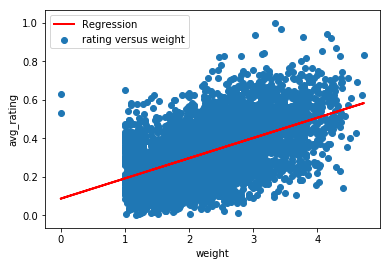

In [30]:
x = subset['weight']
y_actual = subset['avg_rating']
y_expected = result.params['Intercept'] + result.params['weight'] * x

scatter(x=x, y=y_actual, label='rating versus weight')
plot(x, y_expected, color='red', linewidth=2, label='Regression')
xlabel('weight')
ylabel('avg_rating')
legend(loc='best')

In [32]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~ weight + age_cat', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.04

Params
Intercept                  0.170802
age_cat[T.11~15]          -0.043416
age_cat[T.16~20]          -0.011030
age_cat[T.1~5]            -0.037961
age_cat[T.21 and above]   -0.163195
age_cat[T.6~10]           -0.078627
weight                     0.093448
dtype: float64

R-squared = 0.2968156996896778

p-values
Intercept                   3.544895e-45
age_cat[T.11~15]            8.148697e-06
age_cat[T.16~20]            5.815551e-01
age_cat[T.1~5]              4.252191e-02
age_cat[T.21 and above]     7.758229e-02
age_cat[T.6~10]             3.806593e-15
weight                     2.123153e-213
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     337.6
Date:                Sun, 12 Aug 2018   Prob (F-statistic):       

In [16]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~ norm_owned', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.04

Params
Intercept     0.316448
norm_owned    0.530686
dtype: float64

R-squared = 0.04005879547844582

p-values
Intercept     0.000000e+00
norm_owned    1.285992e-44
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     200.5
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           1.29e-44
Time:                        15:45:10   Log-Likelihood:                 2239.1
No. Observations:                4806   AIC:                            -4474.
Df Residuals:                    4804   BIC:                            -4461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std e

In [17]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~  norm_owned+ min_cat', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.089

Params
Intercept            0.301655
min_cat[T.single]    0.093733
norm_owned           0.531020
dtype: float64

R-squared = 0.08864500405354137

p-values
Intercept            0.000000e+00
min_cat[T.single]    3.440172e-56
norm_owned           6.713258e-47
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     233.6
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           1.55e-97
Time:                        15:45:14   Log-Likelihood:                 2363.9
No. Observations:                4806   AIC:                            -4722.
Df Residuals:                    4803   BIC:                            -4702.
Df Model:                           2                                         
Covariance Type: 

In [18]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~  norm_owned+ min_cat +age_cat', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.21

Params
Intercept                  0.395091
min_cat[T.single]          0.072596
age_cat[T.11~15]          -0.044469
age_cat[T.16~20]          -0.019440
age_cat[T.1~5]            -0.172798
age_cat[T.21 and above]   -0.177663
age_cat[T.6~10]           -0.147703
norm_owned                 0.549323
dtype: float64

R-squared = 0.21031904346260133

p-values
Intercept                  2.646653e-296
min_cat[T.single]           6.273887e-39
age_cat[T.11~15]            1.688339e-05
age_cat[T.16~20]            3.596645e-01
age_cat[T.1~5]              5.574185e-19
age_cat[T.21 and above]     6.985954e-02
age_cat[T.6~10]             5.244012e-45
norm_owned                  6.792089e-57
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:               

In [47]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~  norm_owned+ min_cat +age_cat +avg_time', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.27

Params
Intercept                  0.329578
min_cat[T.single]          0.066907
age_cat[T.11~15]          -0.035634
age_cat[T.16~20]          -0.020822
age_cat[T.1~5]            -0.115259
age_cat[T.21 and above]   -0.132451
age_cat[T.6~10]           -0.106076
norm_owned                 0.561822
avg_time                   0.030337
dtype: float64

R-squared = 0.27199756124843466

p-values
Intercept                  4.948388e-210
min_cat[T.single]           6.009692e-36
age_cat[T.11~15]            3.331195e-04
age_cat[T.16~20]            3.069033e-01
age_cat[T.1~5]              9.134448e-10
age_cat[T.21 and above]     1.593899e-01
age_cat[T.6~10]             3.821604e-25
norm_owned                  4.660094e-64
avg_time                    7.976532e-87
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:              

In [21]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~  age_cat +avg_time + min_cat+ norm_votes', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.27

Params
Intercept                  0.331680
age_cat[T.11~15]          -0.035841
age_cat[T.16~20]          -0.019298
age_cat[T.1~5]            -0.115965
age_cat[T.21 and above]   -0.131927
age_cat[T.6~10]           -0.106793
min_cat[T.single]          0.068458
avg_time                   0.030237
norm_votes                 0.540507
dtype: float64

R-squared = 0.2736543452895305

p-values
Intercept                  5.260245e-213
age_cat[T.11~15]            3.027536e-04
age_cat[T.16~20]            3.430645e-01
age_cat[T.1~5]              6.912772e-10
age_cat[T.21 and above]     1.605711e-01
age_cat[T.6~10]             1.665246e-25
min_cat[T.single]           1.335621e-37
avg_time                    1.743628e-86
norm_votes                  1.937510e-66
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:               

In [33]:
#norm_votes + norm_owned + min_cat + max_cat+ age_cat+avg_time


y, X = dmatrices('avg_rating ~  age_cat +avg_time + min_cat+ norm_votes+ weight', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

#R^2 = 0.27

Params
Intercept                  0.167512
age_cat[T.11~15]          -0.049052
age_cat[T.16~20]          -0.011801
age_cat[T.1~5]            -0.040370
age_cat[T.21 and above]   -0.141525
age_cat[T.6~10]           -0.080359
min_cat[T.single]          0.063408
avg_time                   0.005451
norm_votes                 0.497972
weight                     0.083445
dtype: float64

R-squared = 0.35769139650153625

p-values
Intercept                   1.132469e-46
age_cat[T.11~15]            1.560161e-07
age_cat[T.16~20]            5.376083e-01
age_cat[T.1~5]              2.417385e-02
age_cat[T.21 and above]     1.094990e-01
age_cat[T.6~10]             8.926742e-17
min_cat[T.single]           1.748336e-36
avg_time                    1.590909e-03
norm_votes                  1.053974e-63
weight                     2.998305e-130
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                     

In [37]:
y, X = dmatrices('avg_rating ~  age_cat', data=subset, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', result.rsquared
print
print 'p-values'
print result.pvalues
print result.summary()

Params
Intercept                  0.417348
age_cat[T.11~15]          -0.036345
age_cat[T.16~20]          -0.018786
age_cat[T.1~5]            -0.176083
age_cat[T.21 and above]   -0.196562
age_cat[T.6~10]           -0.147020
dtype: float64

R-squared = 0.13891349848871837

p-values
Intercept                  2.409748e-307
age_cat[T.11~15]            7.313796e-04
age_cat[T.16~20]            3.962585e-01
age_cat[T.1~5]              3.492453e-18
age_cat[T.21 and above]     5.470188e-02
age_cat[T.6~10]             1.579635e-41
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     154.9
Date:                Sun, 12 Aug 2018   Prob (F-statistic):          5.96e-153
Time:                        15:59:34   Log-Likelihood:        